<a href="https://colab.research.google.com/github/AndrewKalil/Udacity-ML/blob/master/Starbucks_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

###### portfolio.json

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

###### profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

###### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Library imports**

In [1]:
!pip install dython
!pip install klib
!pip install jupyterthemes
!pip install pandas-profiling==2.10.0

In [2]:

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from pandas.io.json import json_normalize
from dython.nominal import associations

from sklearn import preprocessing

# Visualización de missing values
import missingno as msno

import klib
%matplotlib inline

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


import warnings
warnings.filterwarnings('ignore')

We then ahead and import the dataset files and dispay their content. 

In [3]:
# read potfolio.json
portfolio = pd.read_json('drive/MyDrive/Udacity/Datasets/portfolio.json', orient='records', lines=True)
portfolio



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# read profile.json
profile = pd.read_json('drive/MyDrive/Udacity/Datasets/profile.json', orient='records', lines=True)
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
# read transcript.json
transcript = pd.read_json('drive/MyDrive/Udacity/Datasets/transcript.json', orient='records', lines=True)
transcript


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### Keep in mind that the person who recieves a discound may not know that there was an offer


In [6]:
transcript = transcript.rename(columns={"person": "user_id"})
transcript

,user_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### No we look for missing values

In [7]:
# Missing values in portfolio
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [8]:
# Missing values in profile
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [9]:
# Percentage of missing value in profile
print("The percentage of missing values in profile is {}%".format(round(( profile.isnull().sum()[0] / profile.shape[0]) * 100,2)))

The percentage of missing values in profile is 12.79%


In [10]:
# Missing values in Transcript
transcript.isnull().sum()

user_id    0
event      0
value      0
time       0
dtype: int64

### Now let us go ahead and explore some important features of the data

In [11]:
transcript.groupby('event').count()

,user_id,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


We can notice that out of the offers received (76277), 57725 were viewed and 33579 were completed. This is important to keep in mind for future calculations


In [12]:
offers_completed = transcript.groupby('event').count()['user_id'][0]
offers_received = transcript.groupby('event').count()['user_id'][1]
offers_viewed = transcript.groupby('event').count()['user_id'][2]

print("Out of {} offers received, {}% were viewed and {}% were completed".format(offers_received, round(offers_viewed / offers_received * 100, 2), round(offers_completed / offers_received * 100, 2)))

Out of 76277 offers received, 75.68% were viewed and 44.02% were completed


### Preparing for merge

We notice that each table has a relationship with atleast one other table. Transcript and profile are related by user id. However in profile the column name for user id is just "id". To keep a better track of the data and to facilitate many things later, we will go ahead and rename the column to "user_id".

In [13]:
profile = profile.rename(columns={"id": "user_id"})
profile

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### *First Merge: Transcript and Portfolio*
Now we will go ahead and merge these two previously mentioned tables on "user_id" and we will drop the column that tells us when a user became a memeber.

In [14]:
ProfileTranscript = pd.merge(transcript,
                 profile,
                 on='user_id')
ProfileTranscript.drop('became_member_on', inplace=True, axis=1)
ProfileTranscript

,user_id,event,value,time,gender,age,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,100000.0
...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,78000.0


### Extracting important values from profile

In [15]:
import datetime

cleaned_profile = profile.copy()

#Dropping rows with null information
cleaned_profile.dropna(inplace = True)

#Changing 'id' column name to more appropriate 'customer_id' name
cleaned_profile.rename(columns = {'id': 'user_id'}, inplace = True)

#Changing 'became_member_on' column to a date type
cleaned_profile['became_member_on'] = cleaned_profile['became_member_on'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d').date())

#Calculating number of days as a member 
end = pd.Timestamp('2021-06-01')
end = pd.to_datetime(end)
cleaned_profile['days_as_member'] = np.abs((pd.to_datetime(cleaned_profile['became_member_on']) - end).dt.days)

#Creating 'age_range' column based on 'age'
age_range_list = ['11-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
age_range_bins = [11, 20, 30, 40, 50, 60, 70, 80, 110]
cleaned_profile['age_range'] = pd.cut(profile['age'], bins = age_range_bins, labels = age_range_list, right = False)

cleaned_profile

,gender,age,user_id,became_member_on,income,days_as_member,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1417,50-59
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1484,70-79
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1132,60-69
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1208,60-69
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1298,50-59
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1093,40-49
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,1054,60-69
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1587,40-49
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1912,80+


### Extracting important values from transcript

In [16]:
event_dummies =  pd.get_dummies(transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
transcript_dataset = pd.concat([transcript, event_dummies], axis = 1)
transcript_dataset['days'] = transcript_dataset['time'] / 24
transcript_dataset.drop(columns = ['time'], inplace = True)
transcript_dataset

,user_id,event,value,offer_completed,offer_received,offer_viewed,transaction,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0.00
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,0.00
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},0,0,0,1,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},0,0,0,1,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},0,0,0,1,29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},0,0,0,1,29.75


In [17]:
# separate value columns into different columns
transcript_dataset['offer-or-amount'] = transcript_dataset['value'].apply(lambda x: list(x.keys())[0])
transcript_dataset['id-or-amount'] = transcript_dataset['value'].apply(lambda x: list(x.values())[0])

# changing all offer ids to a unified name: offer_id
trans_offer_dict = {'offer id': 'offer_id'}
transcript_dataset['offer-or-amount'].replace({'offer id':'offer_id'}, inplace = True)
transcript_dataset

,user_id,event,value,offer_completed,offer_received,offer_viewed,transaction,days,offer-or-amount,id-or-amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,0.00,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0.00,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,0.00,offer_id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,0.00,offer_id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,0.00,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},0,0,0,1,29.75,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},0,0,0,1,29.75,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},0,0,0,1,29.75,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},0,0,0,1,29.75,amount,3.53


In [18]:
# Creating the offer DataFrame for transcript dataset
transcript_dataset_offer = transcript_dataset[transcript_dataset['offer-or-amount'] == 'offer_id']
transcript_dataset_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_dataset_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)
transcript_dataset_offer

,user_id,offer_completed,offer_received,offer_viewed,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,1,0,0.00,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0.00,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,1,0,0,29.75,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,1,0,0,29.75,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,0,0,1,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,1,0,0,29.75,fafdcd668e3743c1bb461111dcafc2a4


In [19]:
# Creating the amount DataFrame for transcript dataset
transcript_dataset_amount = transcript_dataset[transcript_dataset['offer-or-amount'] == 'amount']
transcript_dataset_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_dataset_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)
transcript_dataset_amount

,user_id,transaction,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,1,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,0.00,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,1,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,1,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,1,29.75,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,1,29.75,3.53


In [20]:
cleaned_transcript = transcript.copy()
#Changing the 'person' column name to 'user_id'
cleaned_transcript.rename(columns = {'person': 'user_id'}, inplace = True)

# One hot encode event values
event_dummies = pd.get_dummies(cleaned_transcript['event'])
event_dummies.rename(columns = {'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace = True)
cleaned_transcript = pd.concat([cleaned_transcript, event_dummies], axis = 1)

# Change 'time' column to 'days' along with the appropriate values
cleaned_transcript['days'] = cleaned_transcript['time'] / 24
cleaned_transcript.drop(columns = ['time'], inplace = True)

# separate value columns into different columns
cleaned_transcript['offer-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.keys())[0])
cleaned_transcript['id-or-amount'] = cleaned_transcript['value'].apply(lambda x: list(x.values())[0])

# changing all offer ids to a unified name: offer_id
trans_offer_dict = {'offer id': 'offer_id'}
cleaned_transcript['offer-or-amount'].replace({'offer id':'offer_id'}, inplace = True)

# Creating the offer DataFrame for transcript dataset
transcript_dataset_offer = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'offer_id']
transcript_dataset_offer.rename(columns = {'id-or-amount': 'offer_id'}, inplace = True)
transcript_dataset_offer.drop(columns = ['event', 'value', 'offer-or-amount', 'transaction'], inplace = True)

# Creating the amount DataFrame for transcript dataset
transcript_dataset_amount = cleaned_transcript[cleaned_transcript['offer-or-amount'] == 'amount']
transcript_dataset_amount.rename(columns = {'id-or-amount': 'amount'}, inplace = True)
transcript_dataset_amount.drop(columns = ['event', 'value', 'offer-or-amount', 'offer_completed', 'offer_received', 'offer_viewed'], inplace = True)
transcript_dataset_amount

# transcript_offer_clean, transcript_amount_clean = clean_transcript()
# print(transcript_offer_clean)
# print(transcript_amount_clean)

,user_id,transaction,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,1,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,1,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,1,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,1,0.00,18.97
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,1,29.75,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,1,29.75,9.53
306531,a00058cf10334a308c68e7631c529907,1,29.75,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,1,29.75,3.53


### Extracting important values from portfolio

In [21]:
cleaned_portfolio = portfolio.copy()

# creating a unified identifier for the ids of offers: offer_id
cleaned_portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

# One hot encoding the offer_type field, fixing a prefix of 'offer'
offer_dummies = pd.get_dummies(cleaned_portfolio['offer_type'], prefix = 'offer')
cleaned_portfolio = pd.concat([cleaned_portfolio, offer_dummies], axis = 1)
cleaned_portfolio.drop(columns=['offer_type'], inplace=True)

#Separating and one hot encoding the channels field
channels_one_hot = preprocessing.MultiLabelBinarizer()
sep_channels = channels_one_hot.fit_transform(cleaned_portfolio['channels'])
channels_df = pd.DataFrame(data = sep_channels, columns = channels_one_hot.classes_)
cleaned_portfolio = pd.concat([cleaned_portfolio, channels_df], axis = 1)
cleaned_portfolio.rename(columns = {'email': 'channel_email', 'mobile': 'channel_mobile', 'social': 'channel_social', 'web': 'channel_web'}, inplace = True)
cleaned_portfolio.drop(columns=['channels'], inplace=True)
cleaned_portfolio 
# portfolio[portfolio['offer_type'] == 'discount']['id'].to_list()

#Dropping the now former columns
# cleaned_portfolio.drop(columns = ['channels', 'offer_type'], axis = 1, inplace = True)

,reward,difficulty,duration,offer_id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


### Merging

In [22]:
def unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount):
    
    #Initializing a list to append our individual customer dictionaries to
    entries = []
    
    for user_id in user_ids:
        # Extracting user attributes
        user = cleaned_profile[cleaned_profile['user_id'] == user_id]
        age = user['age'].values[0]
        became_member_on = user['became_member_on'].values[0]
        gender = user['gender'].values[0]
        income = user['income'].values[0]
        days_as_member = user['days_as_member'].values[0]
        age_range = user['age_range'].values[0]

        # New features to be added
        total_viewed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_viewed'].sum()
        total_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_received'].sum()
        total_completed = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_completed'].sum()
        total_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].sum()
        avg_spent = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['amount'].mean()
        num_transactions = transcript_dataset_amount[transcript_dataset_amount['user_id'] == user_id]['transaction'].sum()

        # Completed offers
        offer_completed_df = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]
        completed_offer_list = offer_completed_df['offer_id'].tolist()
        completed_bogo = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_bogo'].sum()
        completed_discount = cleaned_portfolio[cleaned_portfolio['offer_id'].isin(completed_offer_list)]['offer_discount'].sum()

        # Offers received
        offers_received = transcript_dataset_offer[transcript_dataset_offer['user_id'] == user_id]['offer_id'].values.tolist()
        bogos = portfolio[portfolio['offer_type'] == 'bogo']['id'].to_list()
        discounts = portfolio[portfolio['offer_type'] == 'discount']['id'].to_list()
        
        #Initializing variables we will use later on down
        discounts_received = 0
        bogos_received = 0

        #Determining whether or not offer is a bogo or discount offer and incrementing appropriate variables
        for offer in offers_received:
            #Iterating through all the bogo offers
            if offer in bogos:
                bogos_received += 1
            #Iterating through all the discount offers
            elif offer in discounts:
                discounts_received += 1

        #Adding all features to a unified dictionary, 'person_entry'
        person_entry = {'user_id': user_id,
                        'age': age,
                        'age_range': age_range,
                        'gender': gender,
                        'income': income,
                        'became_member_on': became_member_on,
                        'days_as_member': days_as_member,
                        'total_completed': total_completed,
                        'total_viewed': total_viewed,
                        'total_received': total_received,
                        'total_spent': total_spent,
                        'avg_spent': avg_spent,
                        'num_transactions': num_transactions,
                        'bogos_received': bogos_received,
                        'completed_bogo': completed_bogo,
                        'discounts_received': discounts_received,
                        'completed_discount': completed_discount,}

        entries.append(person_entry)
    
    #Building our final DataFrame from the entries list
    unified_dataset = pd.DataFrame(entries)
    unified_dataset.to_csv('drive/MyDrive/Udacity/unified_dataset.csv')
    
    return unified_dataset

### Calling the function to generate the unified dataset

In [23]:
# Loop through the customer base and collect data from other datasets
user_ids = cleaned_profile['user_id'].to_list()
# unified_dataset = unify_dataset(user_ids, portfolio, cleaned_portfolio, cleaned_profile, transcript_dataset_offer, transcript_dataset_amount)
unified_dataset = pd.read_csv('drive/MyDrive/Udacity/unified_dataset.csv')
unified_dataset.drop(columns="Unnamed: 0", inplace=True)
unified_dataset

,user_id,age,age_range,gender,income,became_member_on,days_as_member,total_completed,total_viewed,total_received,total_spent,avg_spent,num_transactions,bogos_received,completed_bogo,discounts_received,completed_discount
0,0610b486422d4921ae7d2bf64640c50b,55,50-59,F,112000.0,2017-07-15,1417,1,0,2,77.01,25.670000,3,2,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,75,70-79,F,100000.0,2017-05-09,1484,3,4,4,159.27,22.752857,7,9,3,0,0
2,e2127556f4f64592b11af22de27a7932,68,60-69,M,70000.0,2018-04-26,1132,2,3,4,57.73,19.243333,3,3,1,5,2
3,389bc3fa690240e798340f5a15918d5c,65,60-69,M,53000.0,2018-02-09,1208,5,6,6,36.43,12.143333,3,11,2,6,2
4,2eeac8d8feae4a8cad5a6af0499a211d,58,50-59,M,51000.0,2017-11-11,1298,1,2,3,15.62,3.905000,4,0,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,6d5f3a774f3d4714ab0c092238f3a1d7,45,40-49,F,54000.0,2018-06-04,1093,0,3,3,20.03,2.861429,7,2,1,2,1
14821,2cb4f97358b841b9a9773a7aa05a9d77,61,60-69,M,72000.0,2018-07-13,1054,1,1,3,25.97,3.710000,7,2,1,0,0
14822,01d26f638c274aa0b965d24cefe3183f,49,40-49,M,73000.0,2017-01-26,1587,0,1,3,39.74,4.967500,8,0,0,1,1
14823,9dc1421481194dcd9400aec7c9ae6366,83,80+,F,50000.0,2016-03-07,1912,3,3,3,189.67,13.547857,14,9,3,0,0


In [24]:
def drop_missing_values(df, column, target_column):
    df = df[column].apply(pd.Series)
    
    df_final = df[[target_column]]
    df_final = df_final.dropna()
    df_final = df_final.reset_index()
    
    return df_final
    
def merge_dataset(general_dataset, column, target_column):
    data_normalize = drop_missing_values(general_dataset, column, target_column)
    general_dataset =  general_dataset.reset_index()
    
    final_data = pd.merge(general_dataset, data_normalize.reset_index(), on='index', how="inner")
    final_data.drop(['level_0', 'value'], axis=1, inplace=True)   
    
    return final_data

In [25]:
cleaned_df = merge_dataset(ProfileTranscript, "value", "offer_id")
cleaned_df.drop("index", axis=1, inplace=True)
cleaned_df

,user_id,event,time,gender,age,income,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,F,75,100000.0,ae264e3637204a6fb9bb56bc8210ddfd
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,F,75,100000.0,f19421c1d4aa40978ebb69ca19b0e20d
3,e2127556f4f64592b11af22de27a7932,offer completed,522,M,68,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,e2127556f4f64592b11af22de27a7932,offer completed,522,M,68,70000.0,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...,...,...,...,...
33574,3a298dbf99ef4a23b9b46a1500e56101,offer completed,588,M,58,118000.0,4d5c57ea9a6940dd891ad53e9dbe8da0
33575,bad805c0568d49ae9bf2f046b6ea2be0,offer completed,678,None,118,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
33576,fc966e9c3edc4578a1fb4c6a8c2659c2,offer completed,528,F,60,94000.0,f19421c1d4aa40978ebb69ca19b0e20d
33577,fc966e9c3edc4578a1fb4c6a8c2659c2,offer completed,654,F,60,94000.0,2298d6c36e964ae4a3e7e9706d1fb8c2


In [26]:
portfolio_remanamed_id = portfolio.rename(columns={"id": "offer_id"})
portfolio_remanamed_id

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### *Second Merge: First Merge and Portfolio*

In [27]:
final_data = pd.merge(portfolio_remanamed_id,
                 cleaned_df,
                 on='offer_id')
final_data

,reward,channels,difficulty,duration,offer_type,offer_id,user_id,event,time,gender,age,income
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,F,75,100000.0
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,c4863c7985cf408faee930f111475da3,offer completed,684,None,118,NaN
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,aa4862eba776480b8bb9c68455b8c2e1,offer completed,426,F,61,57000.0
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,M,64,100000.0
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,102e9454054946fda62242d2e176fdce,offer completed,588,F,69,57000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33574,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,be1f25a62a5648f6bdc1887b5e5f365d,offer completed,576,F,93,79000.0
33575,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,a3798355c8a2408d8c329b7f342a5fb7,offer completed,558,F,56,46000.0
33576,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,af5215439a5c4c6f9a0955b609de4851,offer completed,606,F,87,76000.0
33577,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,976931110347490ba94ef6e8db5bd5f4,offer completed,546,M,67,97000.0


In [28]:
columns_to_drop = ['offer_id', 'event']
final_data.drop(columns_to_drop, axis=1, inplace=True)
final_data

,reward,channels,difficulty,duration,offer_type,user_id,time,gender,age,income
0,10,"[email, mobile, social]",10,7,bogo,78afa995795e4d85b5d9ceeca43f5fef,510,F,75,100000.0
1,10,"[email, mobile, social]",10,7,bogo,c4863c7985cf408faee930f111475da3,684,None,118,NaN
2,10,"[email, mobile, social]",10,7,bogo,aa4862eba776480b8bb9c68455b8c2e1,426,F,61,57000.0
3,10,"[email, mobile, social]",10,7,bogo,4b0da7e80e5945209a1fdddfe813dbe0,510,M,64,100000.0
4,10,"[email, mobile, social]",10,7,bogo,102e9454054946fda62242d2e176fdce,588,F,69,57000.0
...,...,...,...,...,...,...,...,...,...,...
33574,2,"[web, email, mobile]",10,7,discount,be1f25a62a5648f6bdc1887b5e5f365d,576,F,93,79000.0
33575,2,"[web, email, mobile]",10,7,discount,a3798355c8a2408d8c329b7f342a5fb7,558,F,56,46000.0
33576,2,"[web, email, mobile]",10,7,discount,af5215439a5c4c6f9a0955b609de4851,606,F,87,76000.0
33577,2,"[web, email, mobile]",10,7,discount,976931110347490ba94ef6e8db5bd5f4,546,M,67,97000.0


### Number of customers in the dataset that completed an offer.





In [29]:
final_customers = final_data[final_data['age'] <= 67]

final_customers = final_customers['user_id'].unique().shape[0]
print("The number of customers in the dataset that completed an offer is: {}. This accuonts for {}% of the customer base in the dataset.".format(final_customers, round(final_customers / profile.shape[0] * 100, 2)))


The number of customers in the dataset that completed an offer is: 9164. This accuonts for 53.91% of the customer base in the dataset.


Because the total number of customers that completed the orders is not above 10000, we will go ahead and work with all of the completed offers. Keeping in mind that the number of rows in the final dataset does not correspond to the total number of people that completed the offers but the number of offers completed by poeple, whether it be repeated customers or not. 

### Now we take a look at the missing values in the final data

In [30]:
final_data.isnull().sum()

reward           0
channels         0
difficulty       0
duration         0
offer_type       0
user_id          0
time             0
gender        1135
age              0
income        1135
dtype: int64

### And Graphically this looks like this

GridSpec(6, 6)

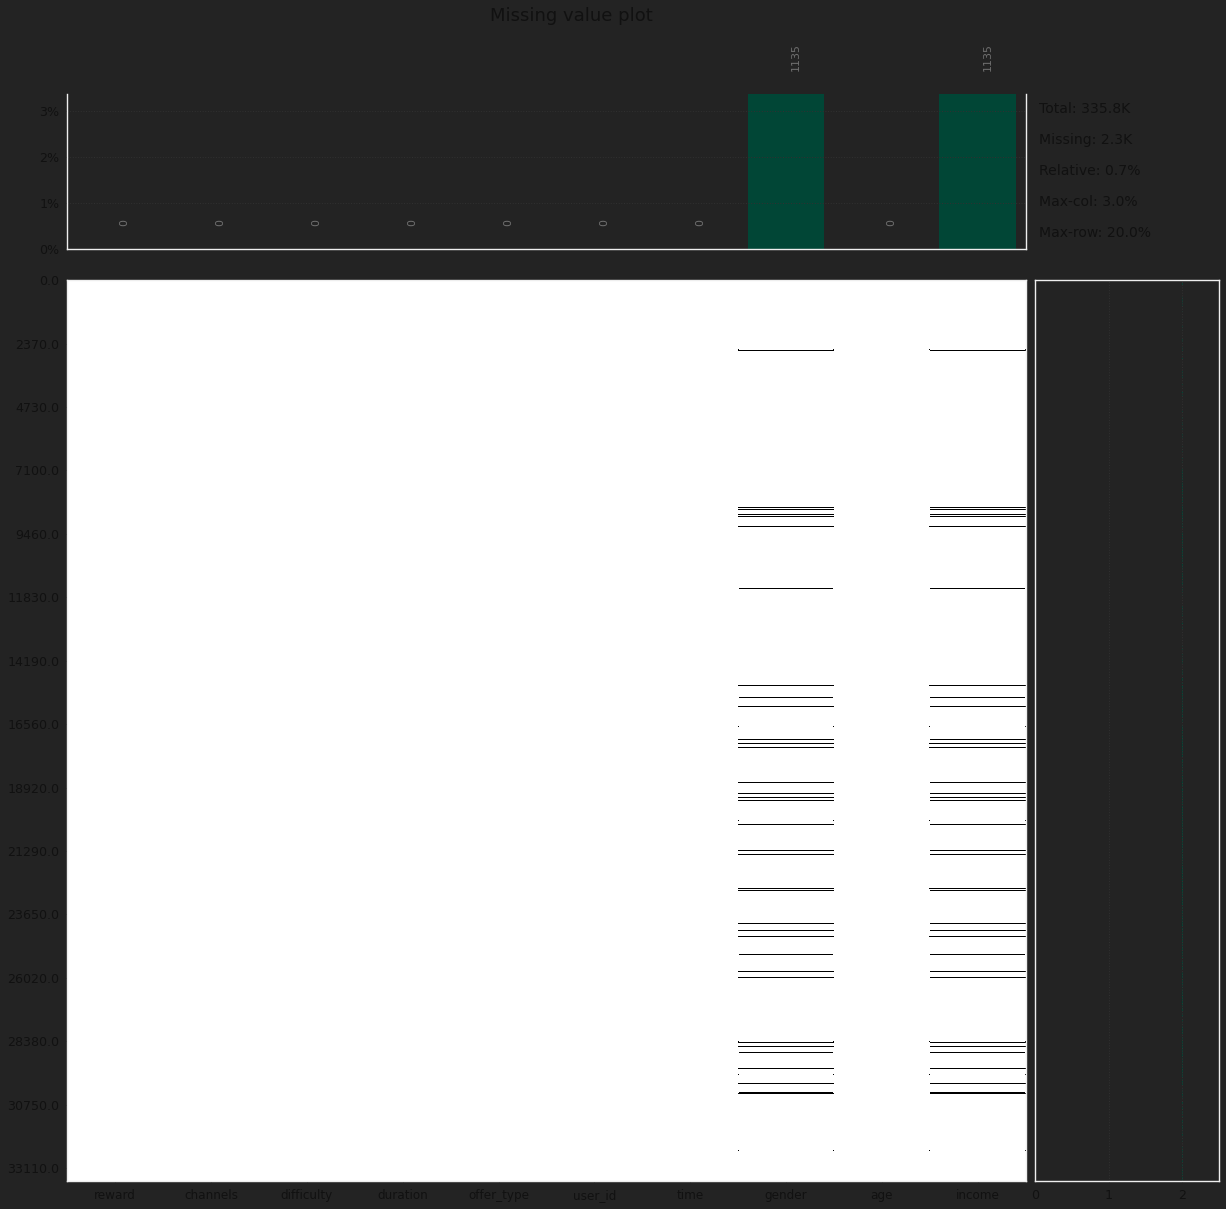

In [31]:
klib.missingval_plot(final_data)

Looking at this we can find that there is a correlation between the income and gender. This most likely points to the customers that did not want to provide much information about themselves. And the data that is available for each customer is the one generated by the Starbucks system. But missing values are no tuseful to us. So we can go ahead and get rid of them

In [32]:
# Delete missing values
final_data.dropna(inplace=True)

### Now we save the data to optimize time when restarting the session. 
We make sure that the saved file can be imported again properly and delete unecessary columns

In [33]:
# Save final data in a csv file
final_data.to_csv('drive/MyDrive/Udacity/final_data.csv')

In [34]:
final_data = pd.read_csv('drive/MyDrive/Udacity/final_data.csv')
final_data.drop('Unnamed: 0', axis= 1, inplace=True)
final_data

,reward,channels,difficulty,duration,offer_type,user_id,time,gender,age,income
0,10,"['email', 'mobile', 'social']",10,7,bogo,78afa995795e4d85b5d9ceeca43f5fef,510,F,75,100000.0
1,10,"['email', 'mobile', 'social']",10,7,bogo,aa4862eba776480b8bb9c68455b8c2e1,426,F,61,57000.0
2,10,"['email', 'mobile', 'social']",10,7,bogo,4b0da7e80e5945209a1fdddfe813dbe0,510,M,64,100000.0
3,10,"['email', 'mobile', 'social']",10,7,bogo,102e9454054946fda62242d2e176fdce,588,F,69,57000.0
4,10,"['email', 'mobile', 'social']",10,7,bogo,a3b9b4bf115e4564933ea2e4bc936843,624,F,79,48000.0
...,...,...,...,...,...,...,...,...,...,...
32439,2,"['web', 'email', 'mobile']",10,7,discount,be1f25a62a5648f6bdc1887b5e5f365d,576,F,93,79000.0
32440,2,"['web', 'email', 'mobile']",10,7,discount,a3798355c8a2408d8c329b7f342a5fb7,558,F,56,46000.0
32441,2,"['web', 'email', 'mobile']",10,7,discount,af5215439a5c4c6f9a0955b609de4851,606,F,87,76000.0
32442,2,"['web', 'email', 'mobile']",10,7,discount,976931110347490ba94ef6e8db5bd5f4,546,M,67,97000.0


### A brief dataset report

In [35]:
report = ProfileReport(final_data, title='Final data report V1.0', dataset={'creator':'Andrew Kalil'},
                        html={'style':{'full_width':True}})

report.to_file("final_data.html")

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
report

### A more statistical visualization

In [37]:
# First we change all float types to int
# Change data type float to int 
for y in final_data.columns:
    if(final_data[y].dtype == np.float64):
        final_data[y] = final_data[y].astype(int)

final_data.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
user_id       object
time           int64
gender        object
age            int64
income         int64
dtype: object

In [38]:
final_data.describe()

,reward,difficulty,duration,time,age,income
count,32444.000000,32444.00000,32444.000000,32444.000000,32444.000000,32444.000000
mean,4.948249,9.31411,7.318734,399.615645,55.826624,69430.803847
std,2.905376,4.20840,1.771882,192.577529,16.809418,21604.250324
min,2.000000,5.00000,5.000000,0.000000,18.000000,30000.000000
25%,2.000000,5.00000,7.000000,234.000000,45.000000,53000.000000
50%,5.000000,10.00000,7.000000,432.000000,57.000000,69000.000000
75%,5.000000,10.00000,10.000000,558.000000,67.000000,85000.000000
max,10.000000,20.00000,10.000000,714.000000,101.000000,120000.000000


Atypical values in age

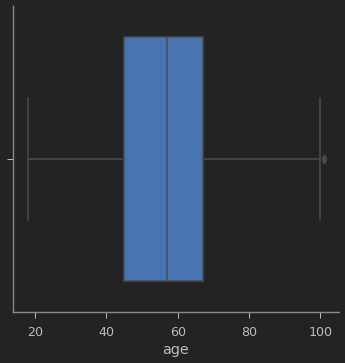

In [39]:
# There are a few atypical values in the dataset due to the maximm age value being 101. 
sns.catplot(x='age', data=final_data, kind='box')
plt.show()

Therefore we go ahead and make an age cut for all customers below the 75% percentile.

In [40]:
final_data = final_data[final_data['age'] <= 67]
print(f'Final number of completed offers is: {final_data.shape[0]}')

Final number of completed offers is: 24579


### Here we will have some usefull functions for plotting

In [41]:
def plot_category_variable(data, column):
    """
    plot_category_variable: Display plot of categorical variables 
    
    Paramters
        column: Name of the column of the dataframe to be displayed
        
    Return 
        None                
    """
    
    plt.figure(figsize=(8, 6)) 
    ax = sns.countplot(x=column, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.suptitle('Frecuency of ' + column)

    plot_percentage(ax, data[column])
    
def plot_percentage(ax, feature):
    """
    plot_percentage: Shows the percentage that the category represents in the overall data set.
    
    Parameteres
        plot: seaborn data type
        feature: Name of the feature of the dataset
        
    Return
        None    
    """
    
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

#### Let us also look if we can find any relationship between the gender and the offer.

In [42]:
genders_plot = final_data.groupby('gender').sum().reward


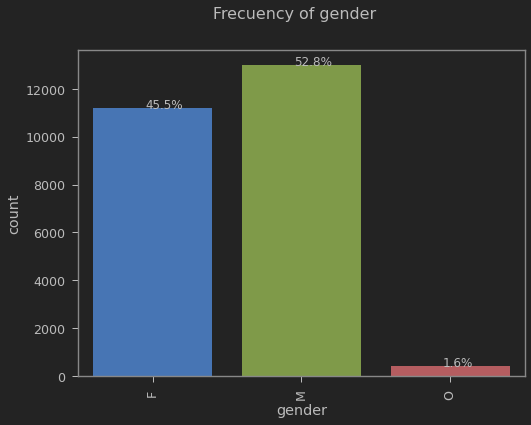

In [43]:
plot_category_variable(final_data, 'gender')

This therefore in this case shows, that men tend to be more attracted to offers. This however is a general assumption and does not take into consideration the type of offer, the age of the person, and how many times a person may complete an offer.

#### Now what if we want to know which type of discount has more impact on a customer base.

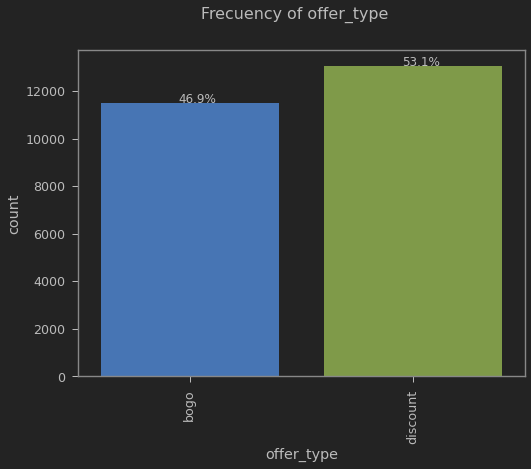

In [44]:
plot_category_variable(final_data, 'offer_type')

We can see that discount type offers have more impact on out dataset customer base. This is probabl due to the fact that many customers complete offers without knowing that that there was a discount. Meaning they may complete a purchase and receive a discount not knowing that it was ever there.

#### Which duration of days for offers had the most impact in this case?

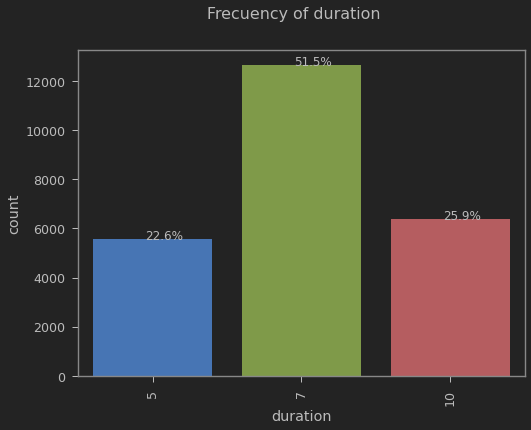

In [45]:
plot_category_variable(final_data, 'duration')

maybe the offers that last a week have a much better impact on the customer base than the rest. 5 Days may be too short of time period and 10 may be way too much time that the customer may even forget.

#### Which reward system had the most impact?

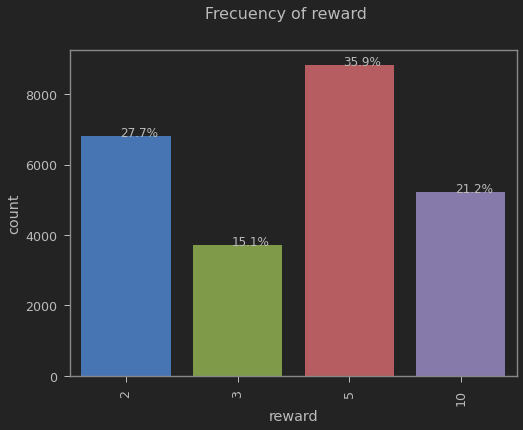

In [46]:
plot_category_variable(final_data, 'reward')

#### How did the channels, if any, impact the sales of this campaign?

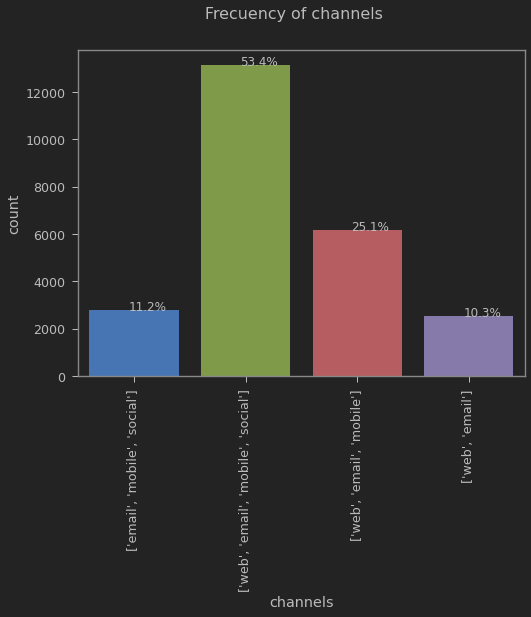

In [47]:
plot_category_variable(final_data, 'channels')

Althought there is a chance that the channels for these offers have little or nothing to do with the completion of the orders. We can assume thanks to the previous graph, that the more platforms a customer receives an offer on, the more likely it is for them to complete it.

In [48]:
numeric_columns = numeric_columns[['age', 'time', 'income']]
for i, col in enumerate(numeric_columns.columns):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    sns.distplot(numeric_columns[col])
    plt.figure(i)

NameError: ignored

We will now see the skewity of each of these density datas.

In [ ]:
numeric_features = final_data.select_dtypes(include=[np.number]).columns
skew_features = final_data[numeric_features].skew().sort_values(ascending = False)

# Print skew features
skew_features

We can see from the previous cell the skewity of some of these data features. But what we mainly want to focus on are the 'age', 'time', and 'income' because they are more customer related. We can notice that time and age have negative skewity while income has positive skewity

#### The Hopkins Statistics
This is used to test the spatial randomness of the data and indicates the clustering tendency and score of said data

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

def hopkins(df):
    """
    hopkins: Take a dataframe and return the Hopkins statistic.
    
    Parameters
        df: Dataframe that takes the numerical values to extract the Hopkins statistic
        
     Return
         statistics_hopkins: Return of Hopkins statistician
    """

    d = df.shape[1]
    # d = len(vars) # columns
    n = len(df)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(df.values)

    rand_df = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(df, axis=0), np.amax(
            df, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            df.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    statistics_hopkins = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(statistics_hopkins):
        print(ujd, wjd)
        H = 0

    return statistics_hopkins   

In [ ]:
hopkins(final_data[numeric_features])


Now we will take a look at the data combinations created by these densities. And how they are affected by three different rescalers: Robust, Standard and Min Max

In [ ]:
columns = ['time', 'income']

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(final_data[['time', 'income']])
robust_df = pd.DataFrame(robust_df, columns = columns)
  
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(final_data[['time', 'income']])
standard_df = pd.DataFrame(standard_df, columns = columns)
  
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(robust_df[['time', 'income']])
minmax_df = pd.DataFrame(minmax_df, columns = columns)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')
  
sns.kdeplot(final_data['income'], ax = ax1, color ='r')
sns.kdeplot(final_data['time'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')
  
sns.kdeplot(robust_df['income'], ax = ax2, color ='red')
sns.kdeplot(robust_df['time'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')
  
sns.kdeplot(standard_df['income'], ax = ax3, color ='black')
sns.kdeplot(standard_df['time'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')
  
sns.kdeplot(minmax_df['income'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['time'], ax = ax4, color ='g')
plt.show()

Preprocessing data function

In [ ]:
def preprocessing_data(df):
    """
    preprocessing_data: It receives a dataframe to which two rescalers RobustScaler and MinMaxScaler are applied.
    
    
    Paramters:
        df: Dataframe to transform.
        
    
    Return
        df: Dataframe columns age, time and income transformed.
    """
    
    
    num_features = ['time', 'income']
    cat_features = ['gender', 'channels', 'reward', 'difficulty', 'duration', 'offer_type']
    
    # Apply RobustScaler
    df[num_features] = preprocessing.RobustScaler().fit_transform(df[num_features])
    
    # Apply MinMaxScaler
    df[num_features] = preprocessing.MinMaxScaler().fit_transform(df[num_features])

    # Set preprocessor for categorical variables
    le = preprocessing.LabelEncoder()
    
    # Apply LabelEncoder
    df[cat_features] = df[cat_features].apply(le.fit_transform)

    return df   

In [ ]:

data_transform = preprocessing_data(final_data)
data_transform

#### The following is sort of a legend used to show what each of these number values in the rows stad for eg: 1, 2, 3, 4

**reward**
* 2: 0
* 3: 1
* 5: 2
* 10: 3

**channels**
* ['email', 'mobile', 'social']: 0
* ['web', 'email', 'mobile', 'social']: 1
* ['web', 'email', 'mobile']: 2
* ['web', 'email']: 3

**difficulty**
* 5: 0
* 7: 1
* 10: 2
* 20: 3

**duration**
* 5: 0
* 7: 1
* 10: 2

**offer type**
* bogo: 0
* discount: 1

**gender**
* F: 0
* M: 1
* O: 2


### Finally we go ahead and drop the user id since it is not really of any use to us anymore.

In [ ]:
data_transform.drop(columns=["user_id"], inplace=True, axis=1)
data_transform